# Final Project Submission

Please fill out:
* Student name: __Paul Williams__
* Student pace: __full time__
* Scheduled project review date/time: __03/23/2020__
* Instructor name: __Dave Baker__

# Data Cleaning

## Imports:

In [147]:
# Data Frame & Visualization libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Statistics and regression libraries
import math
import statistics as stats
import numpy as np
from sklearn.linear_model import LinearRegression

# Feature engineering imports

from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.preprocessing import PolynomialFeatures,StandardScaler

# Validation imports
from sklearn.model_selection import train_test_split,KFold,cross_validate

# Regularization imports
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,LassoLarsIC

import warnings
warnings.filterwarnings('ignore')

## The Data set

In [2]:
housing_df = pd.read_csv('data-files/kc_house_data.csv')
print("Number of row's before cleaning: ", housing_df.shape[0])
print("Number of columns before cleaning: ", housing_df.shape[1])
housing_df.head(3)

Number of row's before cleaning:  21597
Number of columns before cleaning:  21


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


In [3]:
# Data types for each columns
print(housing_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Missing Values

In [4]:
print("Total missing values:", housing_df.isnull().sum().sum()) # I am not using yr_renovated in my model so i will just ignore the nulls
housing_df.isnull().sum()

Total missing values: 6281


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Dealing with them:

In [5]:
print("Waterfront's values:", list(housing_df.waterfront.unique()))

Waterfront's values: [nan, 0.0, 1.0]


I think that the missing values for waterfront was due to lazy data entry and the person entering data probably thought putting nothing into the column is the same as saying 0. I will replace my null values in this column with 0.0

In [52]:
housing_df['waterfront'].fillna(value=0.0, inplace=True)

In [53]:
housing_df['waterfront'].isna().sum()

0

# Exploratory Data Analysis

## Check Duplicates

In [6]:
# We need to check if our ID's are duplicated because that would mean we may have the same houses
print("There are", housing_df['id'].duplicated().sum(), "duplicate entries")

There are 177 duplicate entries


In [7]:
print("Number of houses duplicated: ", housing_df['id'].duplicated().sum())


Number of houses duplicated:  177


In [8]:
housing_df['is_duplicated'] = housing_df['id'].duplicated()
housing_df.query('is_duplicated== True').loc[:, ['id', 'date','price', 'is_duplicated']].sort_values('id')

,id,date,price,is_duplicated
2495,1000102,4/22/2015,300000.0,True
16801,7200179,4/24/2015,175000.0,True
11422,109200390,10/20/2014,250000.0,True
12406,123039336,12/8/2014,244900.0,True
7786,251300110,1/14/2015,358000.0,True
...,...,...,...,...
2492,9407110710,2/26/2015,322000.0,True
4918,9809000020,3/13/2015,1940000.0,True
6340,9828200460,1/6/2015,430000.0,True
15186,9834200305,2/10/2015,615000.0,True


## Drop duplicates:

## Outliers

In [9]:
housing_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


33 bedrooms seems suspicious

In [10]:
housing_df.query('bedrooms==33')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_duplicated
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,False


I dont think 33 people can share 2 bathrooms. Likely a data entry error. So lets find similar dimension houses to it and fill it with the median amount of bedrooms.

In [11]:
# Query out houses with similar dimensions to our outlier then take the median bedrooms for those dimensions
# Median ignores the fact that the outlier is actually in this list
median_outlier = housing_df.query("bathrooms<=1.75 and sqft_living<2000 and floors==1").median()
median_outlier

id               3.841150e+09
price            3.299410e+05
bedrooms         3.000000e+00
bathrooms        1.000000e+00
sqft_living      1.270000e+03
sqft_lot         7.740000e+03
floors           1.000000e+00
waterfront       0.000000e+00
view             0.000000e+00
condition        3.000000e+00
grade            7.000000e+00
sqft_above       1.100000e+03
yr_built         1.955000e+03
yr_renovated     0.000000e+00
zipcode          9.810500e+04
lat              4.754995e+01
long            -1.222880e+02
sqft_living15    1.490000e+03
sqft_lot15       7.789000e+03
is_duplicated    0.000000e+00
dtype: float64

In [12]:
print("Median bedrooms for houses with those dimensions is: ", int(median_outlier[2]))

Median bedrooms for houses with those dimensions is:  3


3 bedrooms is the median for houses similar to our outlier. This sounds more realistic and it was likely a data entry typo.

## Fill outlier

In [13]:
housing_df.query('bedrooms==33')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_duplicated
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,False


In [14]:
housing_df['bedrooms'].replace(33, median_outlier[2], inplace=True)

## Drop unneeded columns

In [18]:
# Run this cell only once 
columns = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'is_duplicated']
new_housing_df= housing_df.drop(axis=1, columns=columns)
print("Number of columns before the drop: ", housing_df.shape[1])
print("Number of columns after the drop: ", new_housing_df.shape[1])
new_housing_df.head(3)

Number of columns before the drop:  22
Number of columns after the drop:  11


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
0,7129300520,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1955
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,1951
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,1933


## Question 1
What is the relationship between my variables like?

### Visualization 1

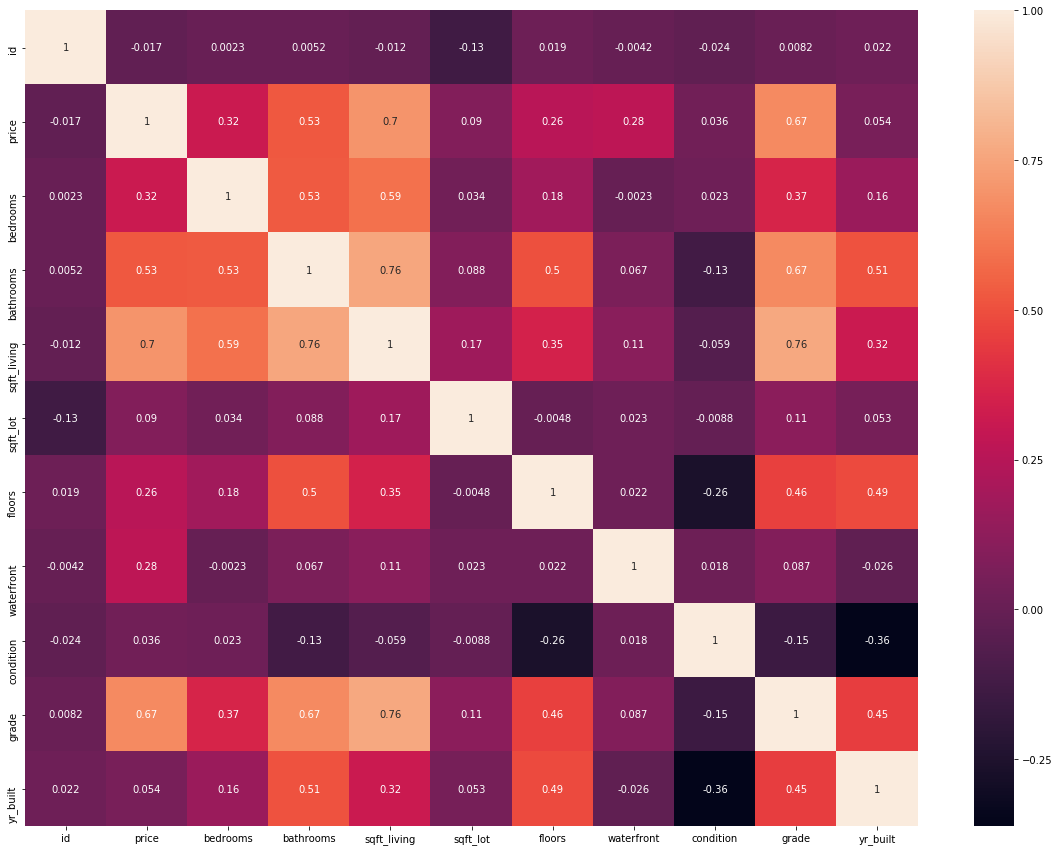

In [145]:
plt.subplots(figsize=(20,15))
sns.heatmap(new_housing_df.corr(), annot=True)
plt.show()

Sqft_living seems to correlate the highest with price. We can attempt to build our model around this. To avoid multi-colinearity we wil pick 2 other variables for our model that correlate well with price and don't correlate at a .7 or above with sqft_living.

In [47]:
new_housing_df.loc[:, ['price', 'sqft_living', 'floors', 'bedrooms']].corr() # my baseline regression features

,price,sqft_living,floors,bedrooms
price,1.000000,0.701917,0.256804,0.315954
sqft_living,0.701917,1.000000,0.353953,0.593182
floors,0.256804,0.353953,1.000000,0.183721
bedrooms,0.315954,0.593182,0.183721,1.000000


These features seem to be my best bet. They correlate decently with price while staying under .7 with sqft_living.

## Question 2
Does having more bathrooms than bedrooms make the price of a house more expensive? If so does this prove a potential better group of predictors that also manage to encompass sqft_living without directly including it?


To tackle this question i will round up my bathrooms into a total room count. This is because having a .25 bathroom means you have 1 full room with just a toilet and sink. Having a .5 bathroom means you have 1 full room with 2 plumbing fixtures etc. I will consider Bathrooms like this as additional rooms.

In [25]:
bed_bath_df = new_housing_df.loc[:,['price', 'bathrooms', 'bedrooms']]
bed_bath_df['bathroom_count']= bed_bath_df['bathrooms'].apply(np.ceil)
bed_bath_df

,price,bathrooms,bedrooms,bathroom_count
0,221900.0,1.00,3,1.0
1,538000.0,2.25,3,3.0
2,180000.0,1.00,2,1.0
3,604000.0,3.00,4,3.0
4,510000.0,2.00,3,2.0
...,...,...,...,...
21592,360000.0,2.50,3,3.0
21593,400000.0,2.50,4,3.0
21594,402101.0,0.75,2,1.0
21595,400000.0,2.50,3,3.0


In [122]:
house_group1 = bed_bath_df.query('bathroom_count>=bedrooms')
print("There are ", len(house_group1),"Entries in this category")
house_group_1_corr = house_group1.corr()
mean_house_group_1 = house_group1.describe()
mean_house_group_1

There are  6632 Entries in this category


,price,bathrooms,bedrooms,bathroom_count
count,6.632000e+03,6632.000000,6632.000000,6632.000000
mean,6.323105e+05,2.580029,2.929885,3.067551
std,4.783764e+05,0.701589,0.703782,0.751787
min,8.000000e+04,0.500000,1.000000,1.000000
25%,3.603000e+05,2.250000,3.000000,3.000000
50%,5.000000e+05,2.500000,3.000000,3.000000
75%,7.225750e+05,2.750000,3.000000,3.000000
max,7.700000e+06,8.000000,7.000000,8.000000


In [120]:
house_group2 = bed_bath_df.query('bathroom_count<=bedrooms')
print("There are ", len(house_group2),"Entries in this category")
house_group_2_corr = house_group2.corr()
mean_house_group2 = house_group2.describe()
mean_house_group2

There are  20727 Entries in this category


,price,bathrooms,bedrooms,bathroom_count
count,2.072700e+04,20727.000000,20727.000000,20727.000000
mean,5.276845e+05,2.071622,3.400589,2.386115
std,3.360715e+05,0.730571,0.895616,0.883358
min,7.800000e+04,0.500000,1.000000,1.000000
25%,3.195000e+05,1.500000,3.000000,2.000000
50%,4.475000e+05,2.250000,3.000000,3.000000
75%,6.350000e+05,2.500000,4.000000,3.000000
max,7.060000e+06,7.500000,11.000000,8.000000


In [141]:
print("The difference in average house group price is: $", round(mean_house_group_1['price'][1]-mean_house_group2['price'][1],2))

The difference in average house group price is: $ 104626.02


In [173]:
house_group_1_corr.loc[:,['price','bedrooms', 'bathroom_count']] # Check the correlation of these groups for clarity

,price,bedrooms,bathroom_count
price,1.000000,0.476167,0.543338
bathrooms,0.583769,0.840585,0.956727
bedrooms,0.476167,1.000000,0.877719
bathroom_count,0.543338,0.877719,1.000000


In [172]:
house_group_2_corr.loc[:,['price','bedrooms', 'bathroom_count']] 

,price,bedrooms,bathroom_count
price,1.000000,0.340392,0.467940
bathrooms,0.498257,0.587193,0.966650
bedrooms,0.340392,1.000000,0.563145
bathroom_count,0.467940,0.563145,1.000000


The correlation goes up with bedrooms and price in these groups. This could mean that bedrooms with a combination of bathroom count are better predictors than sqft_living. Yes higher amount of these rooms would encompass a higher sqft_living. I would be more willing to put my money on these predictors.

### Visualization 2
Bar chart comparing group 1 and group 2

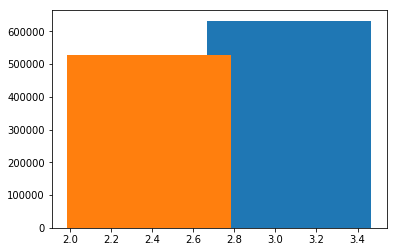

In [69]:
x1 = house_group1['bathroom_count'].mean()
y1 = house_group1['price'].mean()
x2 = house_group2['bathroom_count'].mean()
y2 = house_group2['price'].mean()
plt.bar(x1,y1)
plt.bar(x2,y2)
plt.show()

## Question 3

What is the value of having more than 3 bedrooms?

In [107]:
bedrooms_df = new_housing_df.loc[:,['price', 'bedrooms']]
greater_than_3 = bedrooms_df.query('bedrooms>=4')

In [108]:
less_than_4 = bedrooms_df.query('bedrooms<=3')

In [109]:
print("There are ", len(greater_than_3), "Houses with 3 or bedrooms")
mean_greater_than_3 = greater_than_3.describe()
mean_greater_than_3

There are  8816 Houses with 3 or bedrooms


,price,bedrooms
count,8.816000e+03,8816.000000
mean,6.711931e+05,4.268376
std,4.589409e+05,0.574661
min,1.000000e+05,4.000000
25%,3.885000e+05,4.000000
50%,5.650000e+05,4.000000
75%,7.976250e+05,4.000000
max,7.700000e+06,11.000000


In [151]:
print("The mean house price in group 1 is: $", round(mean_greater_than_3['price'][1],2))

The mean house price in group 1 is: $ 671193.14


In [152]:
print("There are ", len(less_than_4), "Houses with 3 or less bedrooms")
mean_less_than_4 = less_than_4.describe()
mean_less_than_4

There are  12781 Houses with 3 or less bedrooms


,price,bedrooms
count,1.278100e+04,12781.000000
mean,4.500075e+05,2.753384
std,2.506115e+05,0.465278
min,7.800000e+04,1.000000
25%,2.890000e+05,3.000000
50%,4.000000e+05,3.000000
75%,5.450000e+05,3.000000
max,3.800000e+06,3.000000


In [153]:
print("The mean house price in group 2 is: $", round(mean_less_than_4['price'][1],2))

The mean house price in group 2 is: $ 450007.54


In [111]:
print("Difference in house price between the 2 groups is: $", round(mean_greater_than_3['price'][1]-mean_less_than_4['price'][1],2))

Difference in house price between the 2 groups is: $ 221185.61


### Visualization 3

bar chart comparing group 1 and group 2

As you can see, Bedroom and Bathroom although they correlate less with price than sqft_living, they could work a bit better as predictors for my linear regression model.

# Regression Model

the sqft living is such a powerful predictor but i feel like it’s not telling the whole truth
and including it makes you run into multi collinearity issues with other predictors. This would mean i would have to drop the other predictors and use sqft living only if i wanted to include it.
I feel like my model would heavily generalize based on the sqft living feature and
if it was given a data set of houses in bad neighbourhoods that had less bathrooms than rooms but high sqft living it would get the price prediction wrong a lot of the time.
so i am thinking of using more predictors with less correlation to price and less correlation with each other and dropping sqft living completely.
I honestly think a combination of bathrooms, floors, waterfront and grade tell the story better

Bathrooms, waterfront, and grade, maybe floors

In [175]:
new_housing_df.query('sqft_living>=1000 and bathrooms<=bedrooms and floors>=1').describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,1.932700e+04,1.932700e+04,19327.000000,19327.000000,19327.000000,1.932700e+04,19327.000000,17217.000000,19327.000000,19327.000000,19327.000000
mean,4.580074e+09,5.443805e+05,3.491126,2.146026,2147.812387,1.524977e+04,1.501087,0.006563,3.419310,7.716821,1971.914524
std,2.879127e+09,3.405984e+05,0.845765,0.698282,840.407486,3.986405e+04,0.531818,0.080750,0.648752,1.102976,28.737089
min,1.000102e+06,9.500000e+04,1.000000,0.500000,1000.000000,5.200000e+02,1.000000,0.000000,1.000000,4.000000,1900.000000
25%,2.122059e+09,3.300000e+05,3.000000,1.750000,1520.000000,5.250000e+03,1.000000,0.000000,3.000000,7.000000,1954.000000
50%,3.904931e+09,4.620000e+05,3.000000,2.250000,1980.000000,7.800000e+03,1.500000,0.000000,3.000000,7.000000,1976.000000
75%,7.308750e+09,6.500000e+05,4.000000,2.500000,2590.000000,1.089000e+04,2.000000,0.000000,4.000000,8.000000,1996.000000
max,9.900000e+09,7.060000e+06,11.000000,7.500000,10040.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,2015.000000


In [178]:
new_housing_df.query('sqft_living>=1000 and bathrooms>=bedrooms and floors>=1').describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,1.354000e+03,1.354000e+03,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1189.000000,1354.000000,1354.000000,1354.000000
mean,4.729366e+09,7.884507e+05,2.670606,2.975812,2463.771787,19494.236337,1.889956,0.035324,3.228213,8.451994,1987.127031
std,2.946748e+09,6.988770e+05,0.832227,0.916868,1433.851173,66597.956985,0.592266,0.184675,0.539964,1.415096,29.133205
min,7.600136e+06,1.120000e+05,1.000000,1.000000,1000.000000,600.000000,1.000000,0.000000,1.000000,5.000000,1900.000000
25%,2.277425e+09,4.110000e+05,2.000000,2.250000,1432.500000,1778.250000,1.500000,0.000000,3.000000,8.000000,1978.000000
50%,3.903350e+09,5.679750e+05,3.000000,3.000000,1935.000000,5006.000000,2.000000,0.000000,3.000000,8.000000,2001.000000
75%,7.588450e+09,8.637500e+05,3.000000,3.500000,3137.500000,11068.250000,2.000000,0.000000,3.000000,9.000000,2007.000000
max,9.839301e+09,7.700000e+06,7.000000,8.000000,13540.000000,982278.000000,3.500000,1.000000,5.000000,13.000000,2015.000000


### Feature Selection & Extraction

In [ ]:
new_housing_df.query('yr_built>=1980 and yr_built<=2000').corr()

### Linear Regression

In [54]:
regression_baseline = new_housing_df.loc[:,['price', 'floors', 'bedrooms', 'sqft_living']]
regression_baseline

,price,floors,bedrooms,sqft_living
0,221900.0,1.0,3,1180
1,538000.0,2.0,3,2570
2,180000.0,1.0,2,770
3,604000.0,1.0,4,1960
4,510000.0,1.0,3,1680
...,...,...,...,...
21592,360000.0,3.0,3,1530
21593,400000.0,2.0,4,2310
21594,402101.0,2.0,2,1020
21595,400000.0,2.0,3,1600


In [179]:
X = regression_baseline.drop('price',axis=1)
y = regression_baseline['price']

In [180]:
# Setting up the LEARNER
model_skl = LinearRegression(fit_intercept=True)

# Actually LEARNING
model_skl.fit(X,y)

# Evaluating performance
r2 = model_skl.score(X,y)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# Understanding the LEARNED model
est_a = model_skl.intercept_
est_b = model_skl.coef_
print('constant: {}'.format(round(est_a,4)))
print('coeficients: real {} vs {} estimated'.format(b,est_b.round(4)))

R2 = 0.51
constant: 88049.7365


NameError: name 'b' is not defined

In [48]:
# Visualize relationship between our variables and price

(21597, 4)


,price,floors,bedrooms,sqft_living
0,221900.0,1.0,3,1180
1,538000.0,2.0,3,2570
2,180000.0,1.0,2,770
3,604000.0,1.0,4,1960
4,510000.0,1.0,3,1680


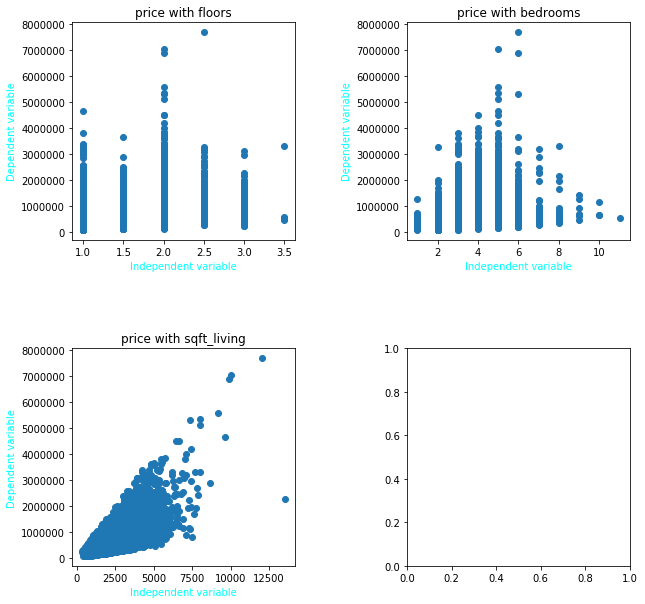

In [57]:
y = regression_baseline.loc[:,['price']]
x = regression_baseline.loc[:,['floors']]
x2 = regression_baseline.loc[:,['bedrooms']]
x3 = regression_baseline.loc[:,['sqft_living']]
# x4 = regression_baseline.loc[:,['yr_built']]


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)



ax[0][0].set_xlabel('Independent variable', color="cyan")
ax[0][0].set_ylabel('Dependent variable', color="cyan")
ax[0][1].set_xlabel('Independent variable', color="cyan")
ax[0][1].set_ylabel('Dependent variable', color="cyan")
ax[1][0].set_xlabel('Independent variable', color="cyan")
ax[1][0].set_ylabel('Dependent variable', color="cyan")
# ax[1][1].set_xlabel('Independent variable', color="cyan")
# ax[1][1].set_ylabel('Dependent variable', color="cyan")

ax[0][0].title.set_text('price with floors')
ax[0][0].scatter(x, y)
ax[0][1].title.set_text('price with bedrooms')
ax[0][1].scatter(x2, y)
ax[1][0].title.set_text('price with sqft_living')
ax[1][0].scatter(x3, y)
# ax[1][1].title.set_text('price with yr_built')
# ax[1][1].scatter(x4, y)





print(regression_baseline.shape)
regression_baseline.head()



In [56]:
regression_baseline.query('sqft_living>12500')

,price,floors,bedrooms,sqft_living
12764,2280000.0,3.0,7,13540
